In [1]:
# Copyright 2020 Bimghi Choi. All Rights Reserved.
# 예측 + 투자전략 시스템

# _*_ coding: utf-8 _*_

from tensorflow import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]='0, 1'

In [2]:
import util
import preprocess as prepro
import models
import learn
from learn import GenerateResult
import math
import datetime

In [3]:
#tf.keras.backend.set_floatx('float64')

In [4]:
import gc
gc.collect()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
#    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
    #tf.config.experimental.set_virtual_device_configuration(
    #    gpus[1],
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
    print(e)

In [5]:
file_name = '~/Data/kospi200f_809_0403.csv'
item_name = 'kospi200f_reinfo_809'
train_start = '2000-01-31'
train_end = '2019-01-02'
test_start = '2019-01-02'
test_end = '2020-05-15'

remove_columns = ['date', '종가', '시가', '고가', '저가']
target_column = '종가'
input_columns = []
target_type = 'rate'

model_name = 'ddaeryuble2'
channel = False

trans_day = 1

target_alpha = 100
future_day = 40
train_end_idx = -20
n_timestep = 120
time_interval = 1
input_size = 809
n_unit = 800
batch_size = 32
learning_rate = 0.0005
epochs = 399
comment = "20일 예측을 위해 40일 예측 training"

alpha = 0.5
beta = 0.1

checkpoint_path = model_name + "/pred"+str(future_day)+"_trans"+str(trans_day)+".ckpt"

In [6]:
dataframe = util.read_datafile(file_name)
df = dataframe.copy()
#df = prepro.target_conversion(df, target_column, future_day, type=target_type)
for i in range(len(df[target_column]) -future_day):
    df.loc[i, target_column] = ((df.loc[i + future_day, target_column] - df.loc[i, target_column]) / df.loc[i, target_column]) * target_alpha 

In [7]:
df.head(20)

,date,시가지수(포인트),고가지수(포인트),저가지수(포인트),종가지수(포인트),수익률(%),수익률 (1주)(%),수익률 (1개월)(%),수익률 (3개월)(%),수익률 (6개월)(%),...,"주요상품선물_천연가스(선물, NYMEX)($/mmBtu)",주요상품선물_금(선물)($/ounce),주요상품선물_은(선물)($/ounce),주요상품선물_알루미늄(선물)($/ton),주요상품선물_옥수수(최근월물)(￠/bu),대두박(￠/bu),종가,시가,고가,저가
0,2000-01-31,-0.218225,-0.493106,-0.400439,-0.223565,0.212872,1.352924,-0.851790,-0.382658,-0.162615,...,1.653438,-0.853010,0.974513,0.827681,0.373581,0.614542,-4.974916,116.85,120.10,116.65
1,2000-02-01,-0.213200,-0.230417,-0.373954,-0.595373,-0.407635,1.808646,-1.074203,-1.707405,-0.490731,...,1.687061,-0.039689,0.193571,1.002058,0.594935,0.706918,-3.034244,120.85,121.70,115.35
2,2000-02-02,-0.208520,-0.448886,-0.367787,-0.200398,0.696677,2.107257,-0.769928,-1.558400,0.074389,...,1.809524,0.800355,0.031266,0.069626,0.430159,0.725768,-8.104686,116.55,119.70,115.95
3,2000-02-03,-0.204125,-0.216603,-0.062403,-0.021445,0.366314,1.488978,-0.625155,-1.268930,-0.079967,...,1.213642,1.515992,0.623370,0.378121,0.084769,0.352875,-10.775681,119.35,120.25,116.80
4,2000-02-07,-0.200000,0.378008,0.426748,0.592789,0.949260,1.101574,1.281908,-1.288431,1.273730,...,0.689954,3.856851,0.568635,-0.322023,0.518339,0.702038,-13.853698,120.40,123.45,119.75
5,2000-02-08,-0.196110,0.353748,0.677387,0.254527,-0.366454,1.138729,0.998930,-1.329397,0.942469,...,0.332052,2.657684,1.222974,-0.720402,0.474125,0.440887,-15.752577,122.90,123.60,120.95
6,2000-02-09,-0.192447,0.306497,0.819824,0.658684,0.641075,1.076862,1.233568,-1.637689,0.994675,...,0.557674,3.026664,2.114708,-0.407511,0.622228,0.721716,-14.291514,122.40,124.10,121.85
7,2000-02-10,0.330923,0.617187,0.552762,0.366383,-0.311193,0.651653,0.275024,-1.607973,0.269679,...,0.812787,3.316674,1.871659,-0.157431,0.985272,1.379493,-10.419210,120.85,125.05,120.40
8,2000-02-11,0.977388,0.576306,0.048738,-0.013448,-0.428351,0.326747,0.131530,-1.828185,0.546650,...,0.675096,2.384344,0.988933,-0.154629,0.473525,0.907189,-11.294994,123.60,124.75,119.85
9,2000-02-14,-0.649462,-0.806483,-0.954529,-1.222378,-1.533955,-1.217328,-0.075927,-2.486079,0.140712,...,0.504701,1.935983,0.085505,-0.246361,0.529501,0.923675,-8.836207,118.85,119.00,115.25


In [8]:
def loss_mean_square(model, input_data, output_data):
    logits = model(input_data, training=True)
    loss = tf.reduce_mean(tf.square(logits - output_data))
    return loss

In [9]:
"""
def loss_fn_(m, train_x, train_y):
    
    #preds = m(train_x)[:, n_timestep-1, :-1].reshape((-1))
    targets = train_y[:, n_timestep-1, 1:].reshape((-1))
    base_prices = train_x[:, n_timestep-1, :-1].reshape((-1))
    rates = (tagets - bse_prices) / base_prices
    updown = np.sign(targets - base_prices)
    preds = model(train_x)
    
    
    returns = [1.0]
    avg_return = 1.0
    avg_std = 0.0
    state = np.zeros((4))
    state[0] = 1.0 # average return
    state[1] = 0.0 # standard dev. of returns
    state[2] = 1.0
    state[3] = preds[train_x[0]]
    
    model2 = layers.Dense(units=10, activaton='tanh')
    
    #investment rate
    inv_r = np.zeros((len(train_y)))
    best_inv = np.zeros((len(train_y)))
    
    for i in range(len(targets)):
        state[0] = 
        state[1] = 
        state[2] = (len(train_y) - i) / len(train_y) 
        inv_r[i] = model2(state)
        returns.append(rates[i]*inv_r[i] + 1-abs(inv_r[i]))
        
        r = tf.random.normal([100], mean=inv_r[i])
        sharp_ratio = np.zeros((len(r)))
        returns_random = [1.0]

        for j in range(len(r)):  
            returns_random.append(rates[i]*r[j] + 1-abs(r[j]))
            for k in range(i+1, len(train_y)):
                state[0] =
                state[1] = 
                state[2] = (len(train_y) - k) / len(train_y)
                inv_r[k] = model2(state, training=False)
                returns_random.append(rates[k]*inv_r[k] + 1-abs(inv_r[k]))
            avg_return = tf.math.reduce_prod(returns_random)**(1/(len(r)-i))
            std_return = tf.math.reduce_std(returns_random)
            sharp_ratio[j] = avg_return / std_return
        best_return_index = tf.math.argmax(sharp_ratio)
        best_inv[i] = r[best_return_index]

    return tf.math.square(inv_r - best_inv)
"""

"\ndef loss_fn_(m, train_x, train_y):\n    \n    #preds = m(train_x)[:, n_timestep-1, :-1].reshape((-1))\n    targets = train_y[:, n_timestep-1, 1:].reshape((-1))\n    base_prices = train_x[:, n_timestep-1, :-1].reshape((-1))\n    rates = (tagets - bse_prices) / base_prices\n    updown = np.sign(targets - base_prices)\n    preds = model(train_x)\n    \n    \n    returns = [1.0]\n    avg_return = 1.0\n    avg_std = 0.0\n    state = np.zeros((4))\n    state[0] = 1.0 # average return\n    state[1] = 0.0 # standard dev. of returns\n    state[2] = 1.0\n    state[3] = preds[train_x[0]]\n    \n    model2 = layers.Dense(units=10, activaton='tanh')\n    \n    #investment rate\n    inv_r = np.zeros((len(train_y)))\n    best_inv = np.zeros((len(train_y)))\n    \n    for i in range(len(targets)):\n        state[0] = \n        state[1] = \n        state[2] = (len(train_y) - i) / len(train_y) \n        inv_r[i] = model2(state)\n        returns.append(rates[i]*inv_r[i] + 1-abs(inv_r[i]))\n        \n 

In [10]:
def loss_fn_model1(m, train_x, train_y):
    
    targets = tf.reshape(train_y, [-1])
    preds = tf.reshape(m(train_x), [-1])
        
    return tf.keras.losses.MSE(targets, preds)   

In [11]:
def loss_fn_model2(m1, m2, train_x, train_y):
    
    targets = tf.reshape(train_y[:, -1, 0], [-1])
    rates = targets / target_alpha
    preds = tf.reshape(m1(train_x, training=False)[:, -1, 0], [-1])
    updown = tf.cast(tf.math.sign(preds), dtype=tf.float64)        
    profits = 1 + tf.convert_to_tensor(rates, dtype=tf.float64)*updown
    
    returns = [1.0]

    n = len(targets)
    for i in range(n):
        
        # average_return, std of returns, remaining days, preds[0] 
        state = []

        avg_return = tf.cast(tf.math.reduce_prod(returns)**(1/(i+1)), dtype=tf.float64)
        state.append(avg_return)
        state.append(tf.math.reduce_std(returns))
        state.append((n - i) / n)
        state.append(preds[i])
        state = np.array(state).reshape((1, 4))

        model2_pred = tf.math.abs(tf.cast(m2(state, training=True)[0, 0], dtype=tf.float64))
        returns.append(tf.math.multiply(profits[i], model2_pred) + 1-tf.math.abs(model2_pred))
        
    avg_return = tf.math.reduce_prod(returns)**(1/n)
    std_return = tf.math.reduce_std(returns)
    if std_return == 0: 
        sharp_ratio = avg_return
    else: 
        sharp_ratio = avg_return / std_return
    return -alpha*sharp_ratio

In [12]:
def test_model2(m1, m2, test_x, test_y):
    
    targets = tf.reshape(test_y[:, -1, 0], [-1])
    rates = targets / target_alpha
    preds = tf.reshape(m1(test_x, training=False)[:, -1, 0], [-1])
    updown = tf.cast(tf.math.sign(preds), dtype=tf.float64)        
    profits = 1 + rates * updown
    
    returns = [1.0]
    inv_rate = []
    
    n = len(targets)
    for i in range(n):
        
        # average_return, std of returns, remaining days, preds[0] 
        state = np.zeros(4)
        
        state[0] = tf.cast(tf.math.reduce_prod(returns)**(1/(i+1)), dtype=tf.float64)
        state[1] = tf.math.reduce_std(returns)
        state[2] = (n - i) / n        
        state[3] = preds[i]
        state = state.reshape(1, 4)
        
        model2_pred = np.array(m2(state, training=False))[0, 0]
        inv_rate.append(model2_pred)
        returns.append(profits[i]*abs(tf.cast(model2_pred, dtype=tf.float64)) + 1-abs(tf.cast(model2_pred, dtype=tf.float64)))

    return inv_rate

In [13]:
def gradient(model, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model1(model, input_data, output_data)
    return tape.gradient(loss, model.trainable_variables)
def gradient2(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model2(model1, model2, input_data, output_data)
    return tape.gradient(loss, model2.trainable_variables)

In [14]:

#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():
model1 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
model2 = models.DenseLayer(4, 10)

    #cp_callback = tf.keras.callbacks.ModelCheckpoint(
    #    checkpoint_path, verbose=1, save_weights_only=True,
        # 다섯 번째 에포크마다 가중치를 저장합니다
    #    save_freq=5)

#    model.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])
            
#    model2 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
#    model2.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])            

#modle_name = model_name + "tanh"            
#model.save_weights(checkpoint_path)
#model2.save_weights("modle2_"+ checkpoint_path)

In [15]:
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)
early_stopping = learn.EarlyStopping(patience=2, verbose=1)

while True:

    gc.collect()
    
    train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                           current_train_start, current_train_end,
                                                           current_test_start, current_test_end,
                                                           future_day, n_timestep, time_interval)
    
    # input_size, columns reset
    input_size = len(df.columns) - len(remove_columns)
    input_columns = df.columns.copy()

    train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
    test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

    #model.compile(optimizer='adam',
    #          loss=loss_fn)
    #          #callbacks=[cp-callback]
    #          #metrics=['accuracy'])
    
    # the firs training dataset
    train_x = train_x[:train_end_idx]
    train_y = train_y[:train_end_idx]    
    
    #global_step = tf.train.get_or_create_global_step()
    global_step = tf.Variable(0, trainable=False)
    #lr_decay = tf.train.exponential_decay(learning_rate, global_step,
    #                                      train_input.shape[0]/batch_size*5, 0.5, staircase=True)
    lr_decay = tf.compat.v1.train.exponential_decay(learning_rate,global_step, int(len(train_y)/batch_size), 0.96, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    updown = np.sign(test_y[:, -1, 0]).reshape((-1))
    iters = epochs
    basic_epochs = int(epochs / 5)
    for iteration in range(iters):
        batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)
        
        #noise = 2*np.random.randn(batch_size,n_timestep,1)
        #batch_output = batch_output+noise
        #batch_input = encoder(train_input[idx])
        gradients1 = gradient(model1, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
        gradients2 = gradient2(model1, model2, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))

        if iteration % 100 == 0:
            #test_MSE = model.evaluate(test_x, test_y)
            prediction = model1.predict(test_x)
            prediction_MSE = sum((updown - prediction[:, -1, 0]).reshape((-1))**2)/len(test_y)
            print('prediction_MSE =', prediction_MSE)

        if iteration > epochs / 2 and early_stopping.validate(prediction_MSE)==True:
            break
    iters -= basic_epochs
    if iters < basic_epochs: iters = basic_epochs

    print('test dates ' + current_test_start + "~" + current_test_end)
    
    #단순 예측
    prediction1 = model1.predict(test_x)[:, -1, 0].reshape(-1)
    prediction_MSE = sum(test_y[:, -1, 0] - prediction[:, -1, 0]).reshape((-1))**2/len(test_y)
    print('prediction_MSE =', prediction_MSE)

    #수익률 평균, 표준편차에 기반 투자 배분을 고려한 예측
    prediction2 = test_model2(model1, model2, test_x, test_y)
    #prediction_MSE = keras.losses.MSE(updown, prediction2)
    #print('prediction_MSE =', prediction_MSE)
    
    #calculate accuracy
    temp = tf.math.multiply(updown, prediction1)
    accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('accuracy = ', accu)
    
    test_prediction1.append(prediction1)
    test_prediction2.append(prediction2)
    
    # escape from while
    if current_test_end == test_end:
     break

    #train, start dates shift
    current_train_start = df.loc[prepro.date_to_index(df, current_train_start) + trans_day, 'date']
    current_train_end = df.loc[prepro.date_to_index(df, current_train_end) + trans_day, 'date']
    current_test_start = df.loc[prepro.date_to_index(df, current_test_start) + trans_day, 'date']
    if prepro.date_to_index(df, test_end) - prepro.date_to_index(df, current_test_start) < trans_day:
        current_test_end = test_end
    else:
        current_test_end = df.loc[prepro.date_to_index(df, current_test_end) + trans_day, 'date']


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for

step :  2
step :  3
Training process is stopped early....
test dates 2019-02-07~2019-02-07
prediction_MSE = [13.24429043]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 15.624449060993584
prediction_MSE = 4.056553972611766
prediction_MSE = 4.813961392812644
step :  4
Training process is stopped early....
test dates 2019-02-08~2019-02-08
prediction_MSE = [10.55907271]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 3.769628501646366
prediction_MSE = 5.290773548746316
prediction_MSE = 7.6086151524634715
step :  5
Training process is stopped early....
test dates 2019-02-11~2019-02-11
prediction_MSE = [6.3703214]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 18.824647125722777
prediction_MSE = 2.0698589489944084
prediction_MSE = 4.503238064874552
step :  6
Training process is stopped early....
test dates 2019-02-12~2019-02-12
prediction_MSE = [25.77775673]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 

prediction_MSE = 5.868434123403915
prediction_MSE = 9.978211029261729
prediction_MSE = 7.989035863875017
step :  9
Training process is stopped early....
test dates 2019-03-25~2019-03-25
prediction_MSE = [6.44496877]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 6.12988096702702
prediction_MSE = 8.457691178719017
prediction_MSE = 9.24066625893829
step :  10
Training process is stopped early....
test dates 2019-03-26~2019-03-26
prediction_MSE = [10.99952149]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 20.86437688066104
prediction_MSE = 10.623937876950151
prediction_MSE = 15.552381021103656
step :  11
Training process is stopped early....
test dates 2019-03-27~2019-03-27
prediction_MSE = [9.43948518]
accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 9.374633858493553
prediction_MSE = 6.5178399065059835
prediction_MSE = 6.781189607982711
step :  12
Training process is stopped early....
test dates 2019-03-28~2019-03-28
predi

prediction_MSE = 3.5304625092978767
step :  39
Training process is stopped early....
test dates 2019-05-08~2019-05-08
prediction_MSE = [4.97537141]
accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 1.8916800897687267
prediction_MSE = 1.7942492588650225
prediction_MSE = 2.6025271548862747
step :  40
Training process is stopped early....
test dates 2019-05-09~2019-05-09
prediction_MSE = [0.00223281]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.013145691111290603
prediction_MSE = 0.01354386879981817
prediction_MSE = 0.1635222392735649
step :  41
Training process is stopped early....
test dates 2019-05-10~2019-05-10
prediction_MSE = [1.56952705]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.008010582542056
prediction_MSE = 0.1846904634312665
prediction_MSE = 0.06338649201262925
step :  42
Training process is stopped early....
test dates 2019-05-13~2019-05-13
prediction_MSE = [5.95704985]
accuracy =  tf.Tensor(1.0, shape=

prediction_MSE = 2.5427581639406185
step :  69
Training process is stopped early....
test dates 2019-06-20~2019-06-20
prediction_MSE = [0.06865968]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 1.965429379618456
prediction_MSE = 2.7452778714441592
prediction_MSE = 0.19846229836417706
step :  70
Training process is stopped early....
test dates 2019-06-21~2019-06-21
prediction_MSE = [2.98200737]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.6996994246269992
prediction_MSE = 0.6484109381062808
prediction_MSE = 0.13666157440981408
step :  71
Training process is stopped early....
test dates 2019-06-24~2019-06-24
prediction_MSE = [0.71258117]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.01963288770099325
prediction_MSE = 1.215850532254592
prediction_MSE = 7.559586567196902
step :  72
Training process is stopped early....
test dates 2019-06-25~2019-06-25
prediction_MSE = [2.73602865]
accuracy =  tf.Tensor(1.0, shape=(),

prediction_MSE = 0.037816675415630385
prediction_MSE = 0.20758349290136735
prediction_MSE = 0.03905575106843173
step :  100
Training process is stopped early....
test dates 2019-08-02~2019-08-02
prediction_MSE = [0.00030225]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.4075097977469335
prediction_MSE = 0.4548259343500973
prediction_MSE = 0.5499623484226044
step :  101
Training process is stopped early....
test dates 2019-08-05~2019-08-05
prediction_MSE = [19.33870443]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 1.8652425761101208
prediction_MSE = 2.105614900680056
prediction_MSE = 2.1320186244961556
step :  102
Training process is stopped early....
test dates 2019-08-06~2019-08-06
prediction_MSE = [47.22221103]
accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 4.960727436496896
prediction_MSE = 5.29880960244283
prediction_MSE = 4.82495135757155
step :  103
Training process is stopped early....
test dates 2019-08-07~2

prediction_MSE = 0.23941006932750497
prediction_MSE = 0.3728272218577411
prediction_MSE = 0.24346630102280997
step :  130
Training process is stopped early....
test dates 2019-09-18~2019-09-18
prediction_MSE = [0.01451975]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.026980936390757826
prediction_MSE = 10.643139624095056
prediction_MSE = 8.133011893221521
step :  131
Training process is stopped early....
test dates 2019-09-19~2019-09-19
prediction_MSE = [8.13301189]
accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 20.38273940072395
prediction_MSE = 19.695325211942873
prediction_MSE = 17.401040014869068
step :  132
Training process is stopped early....
test dates 2019-09-20~2019-09-20
prediction_MSE = [10.64868427]
accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 14.20620070703086
prediction_MSE = 13.659468583688295
prediction_MSE = 13.686288522537836
step :  133
Training process is stopped early....
test dates 2019-09-23

prediction_MSE = 0.6628258191074252
prediction_MSE = 0.5748477920267447
step :  160
Training process is stopped early....
test dates 2019-11-01~2019-11-01
prediction_MSE = [34.80375198]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 2.2061396525651276
prediction_MSE = 2.196918685513083
prediction_MSE = 2.094267941363853
step :  161
Training process is stopped early....
test dates 2019-11-04~2019-11-04
prediction_MSE = [56.80768332]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.0015515601813262947
prediction_MSE = 3.391654192697047e-05
prediction_MSE = 0.012884861254921276
step :  162
Training process is stopped early....
test dates 2019-11-05~2019-11-05
prediction_MSE = [62.98756539]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.15584436185836026
prediction_MSE = 0.04306215417358672
prediction_MSE = 0.045771915269199326
step :  163
Training process is stopped early....
test dates 2019-11-06~2019-11-06
prediction_MS

prediction_MSE = 2.3303770885517885
step :  190
Training process is stopped early....
test dates 2019-12-13~2019-12-13
prediction_MSE = [45.46702325]
accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 2.719956261713609
prediction_MSE = 2.370081716331928
prediction_MSE = 2.4691664176054395
step :  191
Training process is stopped early....
test dates 2019-12-16~2019-12-16
prediction_MSE = [36.71345653]
accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 8.265441299505483
prediction_MSE = 8.514376746357485
prediction_MSE = 8.024578386826363
step :  192
Training process is stopped early....
test dates 2019-12-17~2019-12-17
prediction_MSE = [56.84015298]
accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 1.0279104345808088
prediction_MSE = 1.0503588850201422
prediction_MSE = 1.0459032901269087
step :  193
Training process is stopped early....
test dates 2019-12-18~2019-12-18
prediction_MSE = [38.23332497]
accuracy =  tf.Tensor(0.0, shape=

prediction_MSE = 6.402628740288719
prediction_MSE = 8.487874174016326
prediction_MSE = 8.270528089724394
step :  221
Training process is stopped early....
test dates 2020-02-03~2020-02-03
prediction_MSE = [0.16600202]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 6.318576260505381
prediction_MSE = 6.371731091615459
prediction_MSE = 4.589740982626665
step :  222
Training process is stopped early....
test dates 2020-02-04~2020-02-04
prediction_MSE = [10.30999914]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 4.034975835975786
prediction_MSE = 5.300452345444739
prediction_MSE = 1.9801604488466182
step :  223
Training process is stopped early....
test dates 2020-02-05~2020-02-05
prediction_MSE = [23.50074229]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 2.141731827600779
prediction_MSE = 6.306529933765205
prediction_MSE = 6.113042101971189
step :  224
Training process is stopped early....
test dates 2020-02-06~2020-02-06

prediction_MSE = 22.58550896442557
prediction_MSE = 25.07583638569122
step :  251
Training process is stopped early....
test dates 2020-03-16~2020-03-16
prediction_MSE = [774.71450545]
accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 22.57542354102503
prediction_MSE = 21.385899149161617
prediction_MSE = 21.048672569038956
step :  252
Training process is stopped early....
test dates 2020-03-17~2020-03-17
prediction_MSE = [857.50858253]
accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 24.717129522369078
prediction_MSE = 21.24418618017677
prediction_MSE = 15.104851679172725
step :  253
Training process is stopped early....
test dates 2020-03-18~2020-03-18
prediction_MSE = [1116.02337695]
accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 16.56720900246279
prediction_MSE = 14.788033389051236
prediction_MSE = 15.069942273885545
step :  254
Training process is stopped early....
test dates 2020-03-19~2020-03-19
prediction_MSE = [1375.8

In [16]:
t1 = np.concatenate(test_prediction1)
t2 = np.concatenate(test_prediction2)

In [17]:
#test_prediction = np.concatenate(test_prediction, axis=0).reshape((-1, n_timestep, 1))
#train_prediction = learn.predict_batch_test(model1, train_x[:batch_size], len(train_x[:batch_size]))

# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴
test_dates, test_base_prices, train_dates, train_base_prices = prepro.get_test_dates_prices(dataframe, test_start, test_end,
                                                      train_start, train_end, n_timestep, time_interval, future_day, target_column)

# 전체 test_oouput 생성
_, test_data = prepro.get_train_test_data(df, target_column, remove_columns,
                                                   train_start, train_end,
                                                   test_start, test_end,
                                                   future_day, n_timestep, time_interval)
_, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

In [18]:
updown = np.sign(test_y[:, -1, 0]).reshape((-1))
#calculate accuracy
temp = tf.math.multiply(updown, t1.reshape((-1)))
accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
print('accuracy = ', accu)

accuracy =  tf.Tensor(0.5562700964630225, shape=(), dtype=float64)


In [19]:
import learn
from learn import GenerateResult

In [20]:
result = GenerateResult(t1, t2, test_y[:, -1, 0].reshape(-1), test_dates, n_timestep, future_day, trans_day)

In [21]:
#result.extract_last_output()
result.convert_price(test_base_prices,conversion_type=target_type)

info : ddaeryuble2_kospi200f_reinfo_809_120_1_40_0.556
MSE : 63.9902 , Accuracy : 0.556
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/ddaeryuble2_kospi200f_reinfo_809_120_1_40_0.556/assets


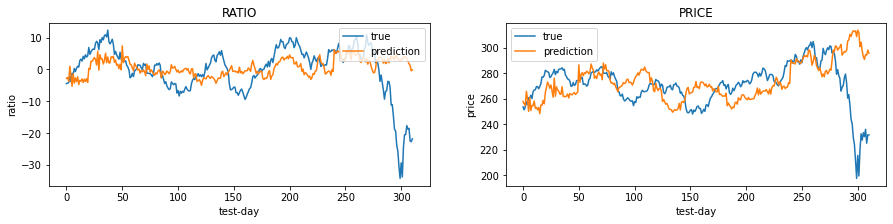

In [22]:
result.evaluation()
result.table()
result.save_result(model_name,item_name,n_unit,target_type,batch_size, n_timestep,time_interval, epochs, alpha, comment)
result.save_visualization()
result.save_model(model2)

In [23]:
    """
    # 변동성 학습
    prediction = learn.predict_batch_test(model, test_x, len(test_x))[:, -1, -1].reshape((-1))
    real = tf.cast(test_y[:, -1, -1].reshape((-1)), tf.float32)
    v_model = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
    optimizer = tf.keras.optimizers.Adam()
    for i in range(20):
        with tf.GradientTape() as tape:
            v_loss = models.loss_prediction_interval(v_model, test_x, prediction, real)
        gradients = tape.gradient(v_loss, v_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, v_model.trainable_variables))
    cnt = 0
    std = tf.reshape(v_model(test_x, training=False)[:, -1, -1], [-1])
    for i in range(len(real)):
        if real[i] > prediction[i] - 1.96 * std[i] and real[i] < prediction[i] + 1.96 * std[i]:
                   cnt += 1
      
    #test_prediction.append(learn.predict_batch_test(model, test_x, len(test_x))) 
    if first_trans:
        test_prediction = prediction
        test_target = test_y
    else:
        test_prediction = np.concatenate([test_prediction, prediction], axis=0)
        test_target = np.concatenate([test_target, test_y], axis=0)
    first_trans = False
    
    test_prediction_x = np.concatenate(test_prediction, axis=0).reshape((-1, n_timestep, 1))
    test_target_y = np.concatenate(test_target, axis=0).reshape((-1, n_timestep, 1))
    
    expected_diff = tf.math.reduce_mean(test_target_y - test_prediction_x)
    #std_diff = tf.math.reduce_std(test_target_y - test_prediction_x)
    std_diff = 1.6
    
    test_prediction = np.a
    """

'\n# 변동성 학습\nprediction = learn.predict_batch_test(model, test_x, len(test_x))[:, -1, -1].reshape((-1))\nreal = tf.cast(test_y[:, -1, -1].reshape((-1)), tf.float32)\nv_model = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)\noptimizer = tf.keras.optimizers.Adam()\nfor i in range(20):\n    with tf.GradientTape() as tape:\n        v_loss = models.loss_prediction_interval(v_model, test_x, prediction, real)\n    gradients = tape.gradient(v_loss, v_model.trainable_variables)\n    optimizer.apply_gradients(zip(gradients, v_model.trainable_variables))\ncnt = 0\nstd = tf.reshape(v_model(test_x, training=False)[:, -1, -1], [-1])\nfor i in range(len(real)):\n    if real[i] > prediction[i] - 1.96 * std[i] and real[i] < prediction[i] + 1.96 * std[i]:\n               cnt += 1\n  \n#test_prediction.append(learn.predict_batch_test(model, test_x, len(test_x))) \nif first_trans:\n    test_prediction = prediction\n    test_target = test_y\nelse:\n    test_prediction = np.